<p style="font-size:32px; font-weight: bolder; text-align: center"> The basics of PIMD </p>
<p style="text-align: center"> <i> authored by: <a href="mailto:eszter.pos@gmail.com"> Eszter Sarolta Pos </a> and <a href="mailto:mariana.rossi@mpsd.mpg.de"> Mariana Rossi </a> </i> </p>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy.fftpack import rfft, irfft
from numpy import linalg as LA
from scipy import constants
import os
from getRDF import RDF

This notebook provides a hands-on counterpart to the "The Basics of Path Integrals" lecture for the MOOC "Path Integrals in Atomistic Modeling". If you haven't done so already, check the [getting started](0-getting_started.ipynb) notebook to make sure that the software infrastructure is up and running. 


In what follows, we are going to do all the preparation needed to run a short PIMD simulation on the analytical 1D harmonic potential.


<p style="color:blue; font-weight:bold"> Questions in blue invite you to reflect on the results you are obtaining. If you are doing these notebooks as part of a course, there might be questions to answer relative to those parts. </p>

## Setting the physical constants

In [6]:
beta = 1   # The reciprocal temperature
lmbd = 0   # The oscillation frequency of the harmonic potential
hbar = 1   # The Planck constant
m = 1      # The mass of the simulated particle

In [7]:
def V(q, lmbd, m):
    """ Function to contain the harmonic potential"""
    return 0.5 * m * lmbd**2 * q**2

def dV(q, lmbd, m):
    """ Function containing the first derivative of the harmonic potential"""
    return m * lmbd**2 * q

#### We initialize our system

In [8]:
P = 8    # The number of beads in the Ring Polymer

p = np.zeros(P)  # The momentum vector of the ring polymer
q = np.zeros(P)  # The position vector of the ring polymer

## Path integral molecular dynamics in a harmonic potential

The Hamiltonian of the system can be written as the sum of the kinetic and potential energy terms
$$
\hat{\mathbf{H}} = \hat{\mathbf{T}} + \hat{\mathbf{V}}
$$

For a path-integral molecular dynamics setup the potential energy can be written as a sum over all ring-polymer beads
$$
V(\mathbf{x}) = \sum_{i=1}^P\frac{1}{2}m\omega_P^2 (x_i-x_{i+1})^2 + \sum_{i=1}^P\frac{1}{2} m \lambda^2 x_i^2
$$
where
$$
\omega_P = \frac{P}{\beta \hbar}
$$
is the frequency of the springs connecting neighbouring beads in the Ring Polymer and $\lambda$ is the frequency of the external harmonic potential.

As one can easily see, the above potential energy matrix is not diagonal.

The potential energy term of the "free" ring polymer (discounting the harmonic potential energy term) is:


$$
\mathbf{x}^T
\begin{pmatrix} 
 m\omega_P^2 & -\frac{m}{2}\omega_P^2 &  0 &  0 & ... & -\frac{m}{2}\omega_P^2 \\
-\frac{m}{2}\omega_P^2 &  m\omega_P^2 & -\frac{m}{2}\omega_P^2 &  0 & ... & 0  \\
 0 & -\frac{m}{2}\omega_P^2 &  m\omega_P^2 & -\frac{m}{2}\omega_P^2 & ... & 0  \\
...&... & ...& ...& ... & ...  \\
-\frac{m}{2}\omega_P^2 &  0 &  0 &  0  & -\frac{m}{2}\omega_P^2  & m\omega_P^2  \\
\end{pmatrix}
\mathbf{x}
$$

or:

$$
\frac{m}{2}\omega_P^2 \mathbf{x}^T
\begin{pmatrix} 
 2 & -1 &  0 &  0 & ... & -1  \\
-1 &  2 & -1 &  0 & ... & 0   \\
 0 & -1 &  2 & -1 & ... & 0   \\
...&... & ...& ...& ... & ... \\
-1 &  0 &  0 &  0  & -1  & 2  \\
\end{pmatrix}
\mathbf{x}
$$


Have a thought about the following. This potential energy matrix might remind you of a general form that you might have seen in your undergraduate studies. Yes, it is how the [Hückel MO method](https://en.wikipedia.org/wiki/H%C3%BCckel_method)
treats cyclic $\pi$-conjugated molecules such as benzene. Remind yourself of the eigenenergies of those systems.

# The free ring polymer

Let us have a look at the internal frequencies of vibration of the free ring polymer

In [9]:
def internalFreq(lmbd, P, beta, hbar, m):
    omegaP = 1/(beta/P)/hbar
    PotMat = np.zeros((P,P))
    intfreq = np.zeros(P)
    
    for i in range(P):
        PotMat[i,i] = 1/2 * m * lmbd**2 + 1 * m * omegaP**2 
    for i in range(P-1):
        PotMat[i,i+1] = - 1/2 * m * omegaP**2
    for i in range(1,P):
        PotMat[i,i-1] = - 1/2 * m * omegaP**2
    
    PotMat[0,P-1] = - 1/2 * m * omegaP**2
    PotMat[P-1,0] = - 1/2 * m * omegaP**2
    
    eigvals=sorted(LA.eigvals(PotMat))
   
    if abs(eigvals[0]) < 1e-10:  # take care with numerics of first eigenvalue
        eigvals[0]=0.0

    intfreq=np.array([np.sqrt(i*2/m) for i in eigvals])
        
    return intfreq

print("The normal mode frequencies of the RP: ", np.round(internalFreq(lmbd, P, beta, hbar, m),3))

The normal mode frequencies of the RP:  [ 0.     6.123  6.123 11.314 11.314 14.782 14.782 16.   ]


Note that for now we have set the value of $\lambda=0$ at the physical constant settings. Therefore, the eigenvalues are taking the form of $\mathbf{\omega}^2=\frac{m}{2}\{0, (2-\sqrt{2})\omega_P^2, (2-\sqrt{2})\omega_P^2, 2 \omega_P^2, ..., 4 \omega_P^2\} $ which are showing pairwise degeneracies and match the analytical form

$$
   \omega_k = 2 \omega_P \sin{\Big(\frac{k \pi}{P}\Big)}
$$

<span style="color:blue; font-weight:700"> How does the maximum normal mode frequency change with the number of beads ($P$), and the inverse temperature ($\beta$)? </span>


We are going to plot the highest $\omega_k$ w.r.t. $P$ and $\beta$.

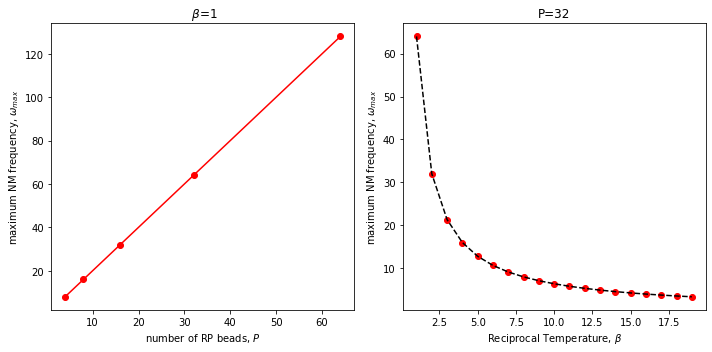

In [10]:
listofP = [4,8,16,32,64]
listofBeta = np.arange(1,20)
listofmaxNM = []

betal = 1
for ip in listofP:
    listofmaxNM.append(internalFreq(lmbd, ip, betal, hbar, m)[-1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(listofP, listofmaxNM, 'o-', color = 'red')
ax1.set_xlabel('number of RP beads, $P$')
ax1.set_ylabel('maximum NM frequency, $\omega_{max}$')
ax1.set_title(r' $ \beta $=1')

P = 32
listofmaxNM = []
for betal in listofBeta:
    listofmaxNM.append(internalFreq(lmbd, P, betal, hbar, m)[-1])
    
ax2.plot(listofBeta, listofmaxNM, 'o', color='red')
ax2.plot(listofBeta, list(64/i for i in listofBeta), '--', color='black')
ax2.set_xlabel(r'Reciprocal Temperature, $ \beta $')
ax2.set_ylabel(r'maximum NM frequency, $\omega_{max}$')
ax2.set_title('P=32')
plt.tight_layout()
plt.show()


# Ring polymer in a potential

Let us now have a look at what happens with the ring polymer in the harmonic potential, where one can write

$$
V(x) = \mathbf{x}^T
\begin{pmatrix} 
 m\omega_P^2 + \frac{m}{2}\lambda^2 & -\frac{m}{2}\omega_P^2 &  0 &  0 & ... & -\frac{m}{2}\omega_P^2 \\
-\frac{m}{2}\omega_P^2 &  m\omega_P^2 + \frac{m}{2}\lambda^2  & -\frac{m}{2}\omega_P^2 &  0 & ... & 0  \\
 0 & -\frac{m}{2}\omega_P^2 &  m\omega_P^2 + \frac{m}{2}\lambda^2  & -\frac{m}{2}\omega_P^2 & ... & 0  \\
...&... & ...& ...& ... & ...  \\
-\frac{m}{2}\omega_P^2 &  0 &  0 &  0  & -\frac{m}{2}\omega_P^2  & m\omega_P^2 + \frac{m}{2}\lambda^2   \\
\end{pmatrix}
\mathbf{x}
$$

We will vary the harmonic oscillator frequency $\lambda$ and understand in which time scales the ring polymer dynamics happen

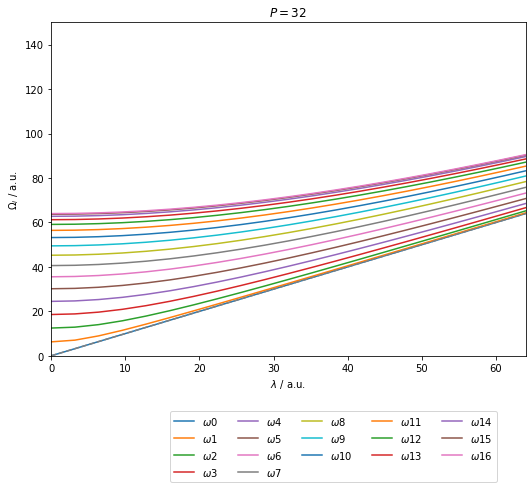

In [18]:
# redefine some parameters for this exercise
P = 32
m = 1
beta = 1
lmbd = np.linspace(0,64,21)
freqMat = np.zeros((len(lmbd),P))

fig, ax1 = plt.subplots(figsize=(7.5,7))

for i, lb in enumerate(lmbd):
    freqMat[i,:] = internalFreq(lb, P, beta, hbar, m)
    
for bead in range(P):
    if bead == 0:
        ax1.plot(lmbd,freqMat[:,bead],'-', label = '$\omega$'+str(bead))
    elif bead%2 ==1:
        ax1.plot(lmbd,freqMat[:,bead],'-', label = '$\omega$'+str(bead//2+1))

plt.plot(lmbd,lmbd,'--', color='grey')
ax1.legend(bbox_to_anchor=(0.95,-0.15),ncol=5)
ax1.set_xlim([0,max(lmbd)])
ax1.set_ylim([0,150])
ax1.set_xlabel('$\lambda$ / a.u.')
ax1.set_ylabel('$\Omega_i$ / a.u.')
ax1.set_title(r'$P=$'+str(P))

plt.tight_layout()
plt.show()

<span style="color:blue; font-weight:700"> Now plot the internal frequencies for P=64 beads. </span>

![Reference Calculation](2-pimd_basics/Internal_frequencies_P32_P64.png)

<span style="color:blue; font-weight:700"> Compared to the physical frequency of the harmonic oscillator, do you see how much higher the frequencies of vibration of the ring polymer in that potential are? Can you translate them to time scales of motion? </span>

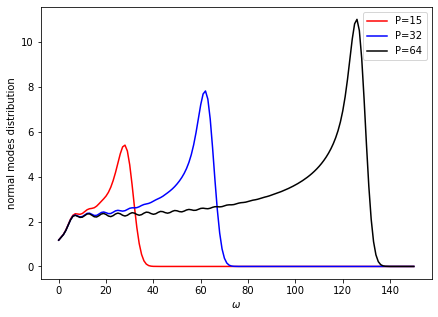

In [14]:
## We are going to fit Gaussian kernels and create a histogram to 
colors = ['red', 'blue', 'black']
fig = plt.subplots(figsize=(7,5))

def gaussian(xx, center, sigma):
    return np.exp(-(xx-center)**2/sigma**2)

lb = 0
for P in [15,32,64]:
    freqs = [i for i in internalFreq(lb, P, beta, hbar, m) if i >= 0]

    xx = np.linspace(0,150,151)
    g = np.zeros(len(xx))

    for nu in freqs:
        g += gaussian(xx,nu,4)
    
    plt.plot(xx, g, '-', color=colors[[15,32,64].index(P)], label = 'P='+str(P))

plt.xlabel(r'$\omega$')
plt.ylabel(r'normal modes distribution')

plt.legend()
plt.show()

<span style="color:blue; font-weight:700">  What are consequences do these high frequencies bring when integrating the equations of motion in path integral molecular dynamics? </span>

#### Setting up the normal mode transformation

The normal modes are obtained as eigenvectors following the diagonalization and lifting of degeneracies of the above potential energy matrix. 

The transformation matrix between Cartesian coordinates and normal modes is as follows 

$$
T_{jk} = \left\{
    \begin{array}\\
        \sqrt{1/P},                    & \mbox{if } \ k = 0 \\
        \sqrt{2/P}\cos{(2\pi j k /P)}, & \mbox{if } \ 1 \leq k \leq P/2-1 \\
        \sqrt{1/P}(-1)^j,              & \mbox{if } \ k = P/2 \\
        \sqrt{2/P}\sin{(2\pi j k /P)}, & \mbox{if } \ P/2+1 \leq k \leq P-1 \\
    \end{array}
\right.
$$

<span style="color:blue; font-weight:700"> Can you check that these are the eigenvectors you were getting for the free ring polymer? </span>

For you reference, we are also providing you with the normal mode transformation routine using Fast Fourier Transforms. This is used in codes where the algorithm changes multiple times between the Cartesian and normal mode coordinates and relies on the NumPy implementation of these transforms. 

In [72]:
# Using Fast Fourier Transforms
def rr2nm(rr):
    P = len(rr)
    nm = np.zeros(P)
    nm[:] = rfft(rr[:])*np.sqrt(2.)/np.sqrt(P)
    nm[0] /= np.sqrt(2.)
    nm[-1] /= np.sqrt(2.)
    for j in range(1,P):
        nm[j] *= -1
    nm[0] /= np.sqrt(P)
    return nm

#print(rr2nm(np.linspace(-1,1,P)))

### Defining normal mode transformation matrix
# The normal mode array is set up in the following way:
#    [ centr, +1, -1, +2, -2, ... ] 
mat = np.zeros((P,P))
for i in range(P):
    for j in range(1,P-1,2):
        mat[i,j] = np.sqrt(2./P)*np.cos(2.*np.pi*(i+1)*(-(j+1)//2)/P)
    for j in range(2,P-1,2):
        mat[i,j] = np.sqrt(2./P)*np.sin(2.*np.pi*(i+1)*(j//2)/P)
    mat[i,P-1] = 1./np.sqrt(P)*(-1)**(i+1)
    mat[i,0] = 1/P

#print(np.matmul(np.linspace(-1,1,P),mat))

In [84]:
# Setting up the normal modes to Cartesian coordinates transform using FFT routines
def nm2rr(nm):
    P = len(nm)
    nm[0] *= np.sqrt(P)
    for j in range(1,P):
        nm[j] /= -1
    nm[-1] *= np.sqrt(2.)
    nm[0] *= np.sqrt(2.)
    nm *= np.sqrt(P)/np.sqrt(2.)
    rr = irfft(nm[:])
    return rr

## Free particle propagator

### Let's set up the time propagation of the ring polymer. 
We will define separate functions for the separate steps of 
$$
\begin{equation*}
p_j ← p_j − \frac{\partial V}{\partial q_j} \frac{\Delta t}{2}
 \tag{1}
\end{equation*}
$$

$$
\begin{equation*}
\tilde{p}_k = \sum_{j=1}^P p_j C_{jk} \qquad  \tilde{q}_k = \sum_{j=1}^P q_j C_{jk} 
 \tag{2a-b}
\end{equation*}
$$

$$
\begin{equation*}
\left( \begin{array}{c}
\tilde{p}_k\\
\tilde{q}_k\\ 
\end{array} \right)
\leftarrow
\left( \begin{array}{cc}
\cos(\omega_k \Delta t) & -m\omega_k \sin(\omega_k \Delta t)\\
\frac{1}{\omega_k \Delta t} \sin(\omega_k \Delta t) & \cos(\omega_k \Delta t)\\ 
\end{array} \right)
\times
\left( \begin{array}{c}
\tilde{p}_k\\
\tilde{q}_k\\ 
\end{array} \right)
\tag{3}
\end{equation*}
$$

$$
\begin{equation*}
p_j = \sum_{k=0}^{P-1} \tilde{p}_k C_{kj} \qquad q_j = \sum_{k=0}^{P-1} \tilde{q}_k C_{kj}
\tag{4a-b}
\end{equation*}
$$

$$
\begin{equation*}
p_j ← p_j − \frac{\partial V}{\partial q_j} \frac{\Delta t}{2}
\tag{5}
\end{equation*}
$$

With the help of the integration scheme above, we can successfully separate the propagation of normal modes from the propagation on the external potential. 

This means that the choice of the time step is solely influenced by the highest frequencies present in the external potential (for potentials which are not harmonic!), while the normal modes are propagated using Eq. (3) in an exact manner.

<span style="color:blue; font-weight:700">  Will the time step be a problem in the harmonic potential? Can you work out how do the internal modes of the ring polymer "couple" to the physical modes in anharmonic potentials? </span>

### Propagation of the momenta of each bead on the external potential

In [22]:
# We reinitialize the system
p = np.zeros(P)  # The momentum vector of the ring polymer
q = np.zeros(P)  # The position vector of the ring polymer

In [85]:
def propExternalPot(p, q, lmbd, m, dt):
    p += -dV(q, lmbd, m)*dt/2
    return p

### Transform from Cartesian coordinates to normal mode coordinates

In [24]:
q = rr2nm(q)
p = rr2nm(p)

### Setting up the free particle propagation

As we mentioned above, using the above defined symplectic integrator scheme for solving the equations of motion enables us to avoid using extremely small timesteps for the propagation of the Ring Polymer.

Now, let us set up the normal mode propagation matrix from Eq. (3).

In [2]:
def freeRPProp(omega, dt,P):
    freeRPProp = np.zeros((2,2,P))

    for k in range(P):
        freeRPProp[0,0,k] = np.cos(omega[k]*dt)
        freeRPProp[1,0,k] = m*omega[k]*np.sin(omega[k]*dt)
        freeRPProp[0,1,k] = 1/m/omega[k]*np.sin(omega[k]*dt)
        freeRPProp[1,1,k] = np.cos(omega[k]*dt)
        
    return freeRPProp

Let us print out how this matrix would act on a ring polymer that has been set up in the coordinate space between the coordinates $x=-1$ and $x=1$ and whose momenta we draw from the Boltzmann distribution at reciprocal temperature $ \beta = 1$.

In [3]:
x = np.linspace(-1,1,P)
p = np.random.normal(loc=0, scale=np.sqrt(m/beta), size=P)

q_nm = rr2nm(x)
p_nm = rr2nm(p)

#normal mode frequencies of the RP
omega = np.zeros(P)
for k in range(1,P):
    omega[k] = 2*P/beta/hbar*np.sin(((k+1)//2)*np.pi/P)*(-1)**(k+1)

#setting the timestep in atomic units for the free RP propagation
dt = 0.01

## Checking out the free RP propagation
for k in range(P):
    (p_nm[k], q_nm[k]) = np.matmul(freeRPProp(omega, dt, P)[:,:,k],(p_nm[k],q_nm[k]))

NameError: name 'P' is not defined

<span style="color:blue; font-weight:700"> Wait a second! We just calculated that the normal mode frequency of the centroid mode $\omega_0$ is zero. How can you calculate the [0,1] element in the above matrix? Do we really have a diverging term?  </span>

<span style="color:blue; font-weight:700"> Correct the code! Which trigonometrical limit comes to your help? </span>

In [170]:
def freeRPProp(omega, dt,P):
    freeRPProp = np.zeros((2,2,P))

    for k in range(P):
        freeRPProp[0,0,k] = np.cos(omega[k]*dt)
        freeRPProp[1,0,k] = m*omega[k]*np.sin(omega[k]*dt)
        if k != 0:
            freeRPProp[0,1,k] = 1/m/omega[k]*np.sin(omega[k]*dt)
        else:
            freeRPProp[0,1,k] = 1/m
        freeRPProp[1,1,k] = np.cos(omega[k]*dt)
        
    return freeRPProp

Note how for the centroid mode (k=0) one propagating step becomes equivalent to a step from the [Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration).

<span style="color:blue; font-weight:700"> Good job! Now that we defined everything necessary for a constant energy NVE run, we should run a few steps. </span>

### Setting up one timestep

In [207]:
def timestep(p, q, beta, P, dt, lmbd, m):
    # do half a timestep on the external potential
    p = propExternalPot(p, q, lmbd, m, dt)
    
    # transform Cartesian to normal modes
    p_nm = rr2nm(p)
    q_nm = rr2nm(q)

    # the free RP propagation
    for k in range(P):
        (p_nm[k], q_nm[k]) = np.matmul(freeRPProp(omega, dt, P)[:,:,k],(p_nm[k],q_nm[k]))
    
    # transform normal modes to Cartesian
    p = nm2rr(p_nm)
    q = nm2rr(q_nm)
    
    # do half a timestep on the external potential
    p = propExternalPot(p, q, lmbd, m, dt)
    
    return p, q

### Running 100 timesteps

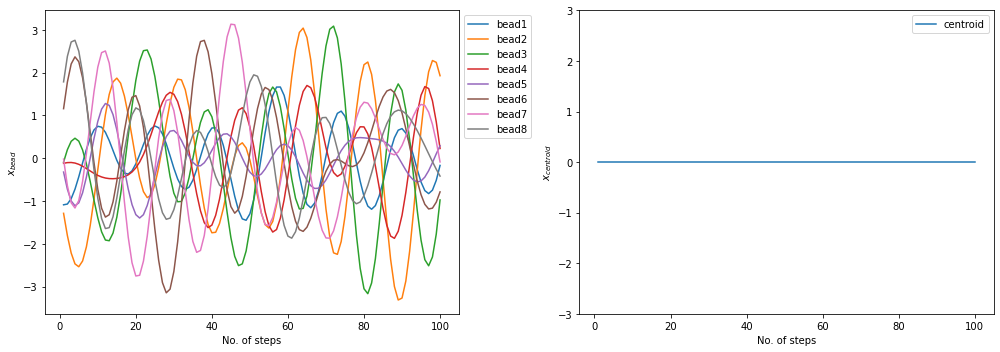

In [261]:
# Setting some run parameters
P = 8
beta = 1
totalTime = 0.1
dt = 0.001
totalSteps = int(totalTime/dt)
qq = np.zeros((totalSteps,P))
centroid = np.zeros(totalSteps)
lmbd = 25  # The oscillation frequency of the harmonic potential
m = 1


#normal mode frequencies of the RP
omega = np.zeros(P)
for k in range(1,P):
    omega[k] = 2*P/beta/hbar*np.sin(((k+1)//2)*np.pi/P)*(-1)**(k+1)

# Initializing the system coordinates and pulling momenta for each bead from the Boltzmann distribution
q = np.linspace(-1,1,P)
p = np.random.normal(loc=0, scale=np.sqrt(m/beta*P), size=P)

for step in range(totalSteps):
    p, q = timestep(p, q, beta, P, dt, lmbd, m)
    for bead in range(P):
        qq[step, bead] = q[bead]
        centroid[step] = np.average(q[:])

        
#plotting how the individual bead coordinates change during the above short simulation we just ran
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

for bead in range(P):
    ax1.plot(np.linspace(1,totalSteps,totalSteps), qq[:,bead], '-', label=r'bead'+str(bead+1))
ax1.legend(bbox_to_anchor=(1.,1))
ax1.set_xlabel('No. of steps')
ax1.set_ylabel('$x_{bead}$')

ax2.plot(np.linspace(1,totalSteps,totalSteps), centroid, '-', label=r'centroid')
ax2.legend(bbox_to_anchor=(1.,1))
ax2.set_xlabel('No. of steps')
ax2.set_ylabel('$x_{centroid}$')
ax2.set_ylim([-3,3])

plt.tight_layout()
plt.show()

<h2>An "almost Ab initio" PIMD simulation of liquid water</h2>

This section requires use of i-PI, so make sure you have it installed and have familiarized yourself with how to run it in the [getting started](0-getting_started.ipynb) section. 

Here we will modify an existing i-PI input to run constant-energy simulations for a small simulation of liquid water, based on the q-TIP4P/f forcefield ([original paper](http://doi.org/10.1063/1.3167790)), run short trajectories and inspect the output.

We will first go to the appropriate folder, create a copy of the template and edit it.  You will need to open a terminal and execute

```
$ cd pimd-mooc/2-pimd_basics/1bead/
```

1. Edit the `base.xml` file. You can use `vi` in the terminal, or open the file with the file editing interface of Jupyter/Jupyterlab. 

Observe the properties and trajectory files that are specified in the <output></output> section.
Make sure it is clear what each part of the input does. For this example we will use the PILE-G thermostat[2] and constant-temperature sampling. We will initially perform a 'by the book' reference molecular dynamics run, with $P=1$ .
For this, we are choosing the time step to be 0.25 fs. Look for the time step specification and check that it reads `<timestep units='femtosecond'> 0.25 </timestep>`. 

You should also set the output prefix to a memorable name - it is recommended to use `<output prefix='base-p1'>` to be compatible with the postprocessing in this notebook.

Then launch i-PI and the driver - either using two terminals or putting i-PI in the background (wait a second or two before launching the driver, to make sure that the server has started and opened the socket)

```
$ i-pi base.xml &> log.ipi &
$ i-pi-driver -u -h driver -m qtip4pf 
```

_NB: the simulation will take a few minutes_

Modify the input so that you’ll run with $P = 6$ beads, by changing the nbeads option of the ```<initialize>``` field. It is advisable to make these changes on a copy of the `pimd_basics/base.xml` input file. You may also want to adjust prefix so that it indicates the new number of beads (e.g. `prefix="base_p-6"` ).

For your convenience, we include in the directory the output files of the PIMD calculation with 32 beads. (It would be a little too long to run here, on this interactive interface)

Compute radial distribution functions for different simulations. You can use any tool of your liking, but we suggest `getRDF.py`. For instance, for one of the replicas in the 6-beads run,

    `$ python ../getRDF.py base_p-6 "pdb" O O 250 0. 5. 0.1`	

Here below, for your convenience we calculate the RDF in the cell calling the function ```RDF()```. This takes some time, so do not be surprised if the plots only apear in some minutes.

 number of beads = 6,  Processing frame 100 

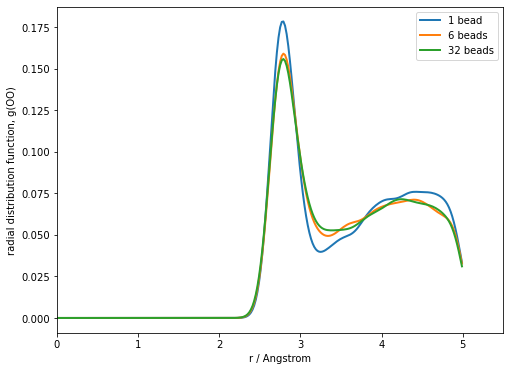

In [4]:
beads = ['1','6']
nbins = 250
rdf = np.zeros(nbins)
dist = np.zeros(nbins)
fig,ax = plt.subplots(figsize = (8,6))

for i in beads:
    if not os.path.exists('2-pimd_basics/' + i + 'bead/'):
        Error = "Please, run the necessary trajectories first with %s"%i+" bead"
        if int(i)>1: Error += "s"
        print(Error)
        continue
    os.chdir('2-pimd_basics/'+i+'bead/')
    RDF('base_p-'+i, "pdb", 'O', 'O', 250, 0., 5., 0.1)
    infile = 'base_p-'+i+'.OO.rdf.dat'
    rdf = np.genfromtxt(infile,usecols = 1) 
    dist = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist, rdf, label=i+' beads' if int(i)>1 else i+' bead', linewidth = 2)
    os.chdir('../')
    
rdf = np.genfromtxt('2-pimd_basics/32bead/base_p-32.OO.rdf.dat', usecols = 1)
dist = np.genfromtxt('2-pimd_basics/32bead/base_p-32.OO.rdf.dat', usecols = 0)
plt.plot(dist,rdf,label='32 beads', linewidth = 2)

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OO)')
ax.set_xlim([0.,5.5])
plt.legend(loc = 1)
plt.show()

Compute the O–H radial distribution function, too. (For instance, for P=32 beads it is as follows)
    
```$ python ../getRDF.py base_p-32 "pdb" O H 300 0. 3. 0.1```


Please, run the necessary trajectories first with 1 bead
Please, run the necessary trajectories first with 6 beads


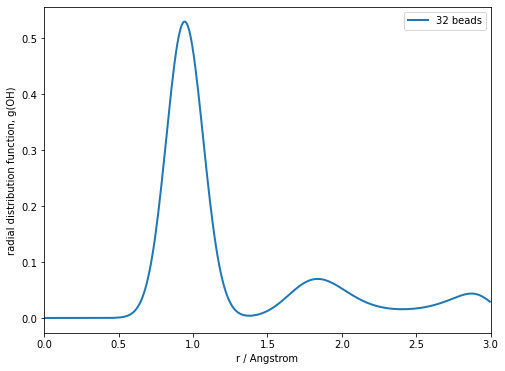

In [8]:
beads = ['1','6']
nbins = 300
rdf = np.zeros(nbins)
dist = np.zeros(nbins)
fig,ax = plt.subplots(figsize=(8,6))

for i in beads:
    if not os.path.exists('2-pimd_basics/' + i + 'bead/'):
        Error = "Please, run the necessary trajectories first with %s"%i+" bead"
        if int(i)>1: Error += "s"
        print(Error)
        continue
    os.chdir('2-pimd_basics/'+i+'bead/')
    RDF('base_p-'+i, "pdb", 'O', 'H', 300, 0., 3., 0.1)
    infile = 'base_p-'+i+'.OH.rdf.dat'
    rdf = np.genfromtxt(infile,usecols = 1) 
    dist = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist,rdf,label=i + ' beads' if int(i)>1 else i +' bead', linewidth = 2)
    os.chdir('../')

rdf = np.genfromtxt('2-pimd_basics/32bead/base_p-32.OH.rdf.dat', usecols = 1)
dist = np.genfromtxt('2-pimd_basics/32bead/base_p-32.OH.rdf.dat', usecols = 0)
plt.plot(dist,rdf,label='32 beads', linewidth = 2)

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OH)')
ax.set_xlim([0.,3.])
plt.legend(loc = 1)
plt.show()

<span style="color:blue; font-weight:700">  What can you say about the convergence of the radial distribution functions with the number of beads? </span>

<span style="color:blue; font-weight:700"> Some points to consider: </span>

In radial distribution functions, small differences with respect to the height and width of peaks of the function can in fact mean large changes in the actual structure of the system under investigation.

Notice, how the curves calculated with different numbers of beads are not equally different over the full range of distances. This can be as the different peaks describe different neighbour-distances among the atoms in the water molecules, namely, the first peak describes the average distance between first neighbours, the second peak describes distance between second neighbours, etc.

